# **EXPERIMENT - 4 NATIVE BAYES FROM SCRATCH**

# IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#CONVERT THE LABELES 0/1

In [4]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# def encode_class(mydata):
#     unique_labels = set(row[-1] for row in mydata)
#     label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
#     for row in mydata:
#         row[-1] = label_to_int[row[-1]]
#     return mydata

#NATIVE BAYES FROM SCRATCH

In [5]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.word_likelihoods = {}
        self.vocab_size = 0
        self.classes = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_docs = len(y)

        # Prior probabilities
        self.class_priors = {c: np.sum(y == c) / n_docs for c in self.classes}

        # Word counts per class
        word_counts = {c: np.zeros(X.shape[1]) for c in self.classes}
        class_word_totals = {c: 0 for c in self.classes}

        for c in self.classes:
            X_c = X[y == c]
            word_counts[c] = np.sum(X_c, axis=0)  # sum counts per feature
            class_word_totals[c] = np.sum(word_counts[c])

        self.vocab_size = X.shape[1]

        # Likelihoods with Laplace smoothing
        self.word_likelihoods = {
            c: (word_counts[c] + self.alpha) /
               (class_word_totals[c] + self.alpha * self.vocab_size)
            for c in self.classes
        }

    def predict(self, X):
        predictions = []
        for x in X:
            class_scores = {}
            for c in self.classes:
                # log prior
                score = np.log(self.class_priors[c])
                # log likelihoods
                score += np.sum(x * np.log(self.word_likelihoods[c]))
                class_scores[c] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return np.array(predictions)

# EVALUATION OF THE CLASS NATIVE BAYES

In [6]:
def evaluate_model(vectorizer, X_train, X_test, y_train, y_test):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    nb = NaiveBayes(alpha=1.0)
    nb.fit(X_train_vec.toarray(), y_train)
    preds = nb.predict(X_test_vec.toarray())

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    print(f"\n=== {vectorizer.__class__.__name__} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", cm)


# EVALUATE THE MODEL

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# def splitting(mydata,ratio):
#     train_num=int(len(mydata)*ratio)
#     train=[];
#     test=list(mydata)
#     while len(train)<train_num:
#         index=random.randrange(len(test))
#         train.append(test.pop(index))
#     return train,test

evaluate_model(CountVectorizer(), X_train, X_test, y_train, y_test)
evaluate_model(TfidfVectorizer(), X_train, X_test, y_train, y_test)


=== CountVectorizer ===
Accuracy : 0.9839
Precision: 0.9645
Recall   : 0.9128
F1-score : 0.9379
Confusion Matrix:
 [[961   5]
 [ 13 136]]

=== TfidfVectorizer ===
Accuracy : 0.9605
Precision: 1.0000
Recall   : 0.7047
F1-score : 0.8268
Confusion Matrix:
 [[966   0]
 [ 44 105]]


#FINDING THE CHANGE IN VALIDATION ACCURACY WITH RESPECT TO THE SMOOTHING PARAMETER

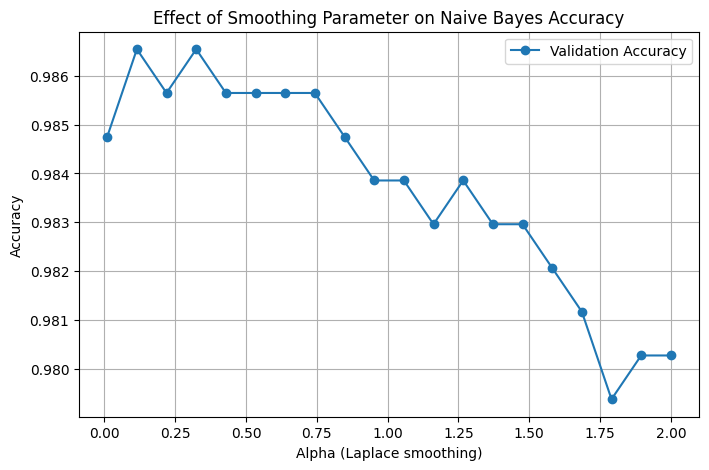

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

alphas = np.linspace(0.01, 2.0, 20)
accuracies = []

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

for a in alphas:
    nb = NaiveBayes(alpha=a)
    nb.fit(X_train_vec.toarray(), y_train)
    preds = nb.predict(X_test_vec.toarray())
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(alphas, accuracies, marker="o", label="Validation Accuracy")
plt.xlabel("Alpha (Laplace smoothing)")
plt.ylabel("Accuracy")
plt.title("Effect of Smoothing Parameter on Naive Bayes Accuracy")
plt.grid(True)
plt.legend()
plt.show()
